# **Notebook 2c**: Results Comparison

## Setup

In [32]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

## Load All Model Results

In [33]:
def load_results(path):
    """Load results_export.json from a model directory."""
    with open(path, 'r') as f:
        return json.load(f)

# Task 2a: Sign Type Detection
models_2a = {
    'Faster R-CNN': load_results('work_dirs/faster_rcnn_sign_type/results_export.json'),
    'RetinaNet': load_results('work_dirs/retinanet_sign_type/results_export.json'),
    'YOLOv8n': load_results('work_dirs/yolov8_sign_type/results_export.json'),
    'YOLOv11n': load_results('work_dirs/yolov11_sign_type/results_export.json'),
    'YOLOv12n': load_results('work_dirs/yolov12_sign_type/results_export.json'),
    'RF-DETR': load_results('work_dirs/rf-detr-sign-type/results_export.json'),
    'CenterNet': load_results('work_dirs/centernet_sign_type/results_export.json'),
}

# Task 2b: Viewing Angle
models_2b = {
    'Faster R-CNN': load_results('work_dirs/faster_rcnn_viewing_angle/results_export.json'),
}

print(f"Loaded {len([m for m in models_2a.values() if m])} models for Task 2a (Sign Type)")
print(f"Loaded {len(models_2b)} models for Task 2b (Viewing Angle)")

Loaded 7 models for Task 2a (Sign Type)
Loaded 1 models for Task 2b (Viewing Angle)


# Task 2a: Sign Type Detection
## Model Overview

In [34]:
# Build comparison table
comparison_data = []

def safe_get_metric(results, *keys, default=0):
    """Try multiple possible keys and return the first one found."""
    for key in keys:
        if key in results.get('metrics', {}):
            return results['metrics'][key]
    return default

def safe_get(results, *path, default='N/A'):
    """Safely navigate nested dict, return default if any key missing."""
    value = results
    for key in path:
        if isinstance(value, dict):
            value = value.get(key)
            if value is None:
                return default
        else:
            return default
    return value

for name, results in models_2a.items():
    # Handle all fields safely
    num_params = safe_get(results, 'model_complexity', 'num_parameters', default=0)
    params_str = f"{num_params/1e6:.2f}" if num_params > 0 else "N/A"
    
    map50 = safe_get_metric(results, 'AP50', 'ap50', 'mAP50')
    map50_95 = safe_get_metric(results, 'mAP', 'map')
    
    fps = safe_get(results, 'speed', 'FPS', default=0)
    fps_str = f"{fps:.1f}" if fps > 0 else "N/A"
    
    batch_size = safe_get(results, 'training', 'batch_size', default='N/A')
    epochs = safe_get(results, 'training', 'epochs', default='N/A')
    
    comparison_data.append({
        'Model': name,
        'mAP@50': f"{map50:.3f}" if map50 > 0 else "N/A",
        'mAP@50:95': f"{map50_95:.3f}" if map50_95 > 0 else "N/A",
        'Parameters (M)': params_str,
        'FPS': fps_str,
        'Batch Size': batch_size,
        'Epochs': epochs
    })

df_comparison = pd.DataFrame(comparison_data)
print("Task 2a: Sign Type Detection - Model Comparison")
print(df_comparison.to_string(index=False))

Task 2a: Sign Type Detection - Model Comparison
       Model mAP@50 mAP@50:95 Parameters (M)  FPS Batch Size Epochs
Faster R-CNN  0.900     0.737          41.32 16.2          8      8
   RetinaNet  0.455     0.404          36.43  5.4          8      8
     YOLOv8n  0.925     0.827            N/A  2.9         16     15
    YOLOv11n  0.912     0.811           2.58 11.8          8      8
    YOLOv12n  0.905     0.808            N/A  3.8         16     15
     RF-DETR  0.703     0.666            N/A 12.3          4     10
   CenterNet  0.687     0.425           0.67  N/A        N/A    N/A


## Performance Metrics Comparison

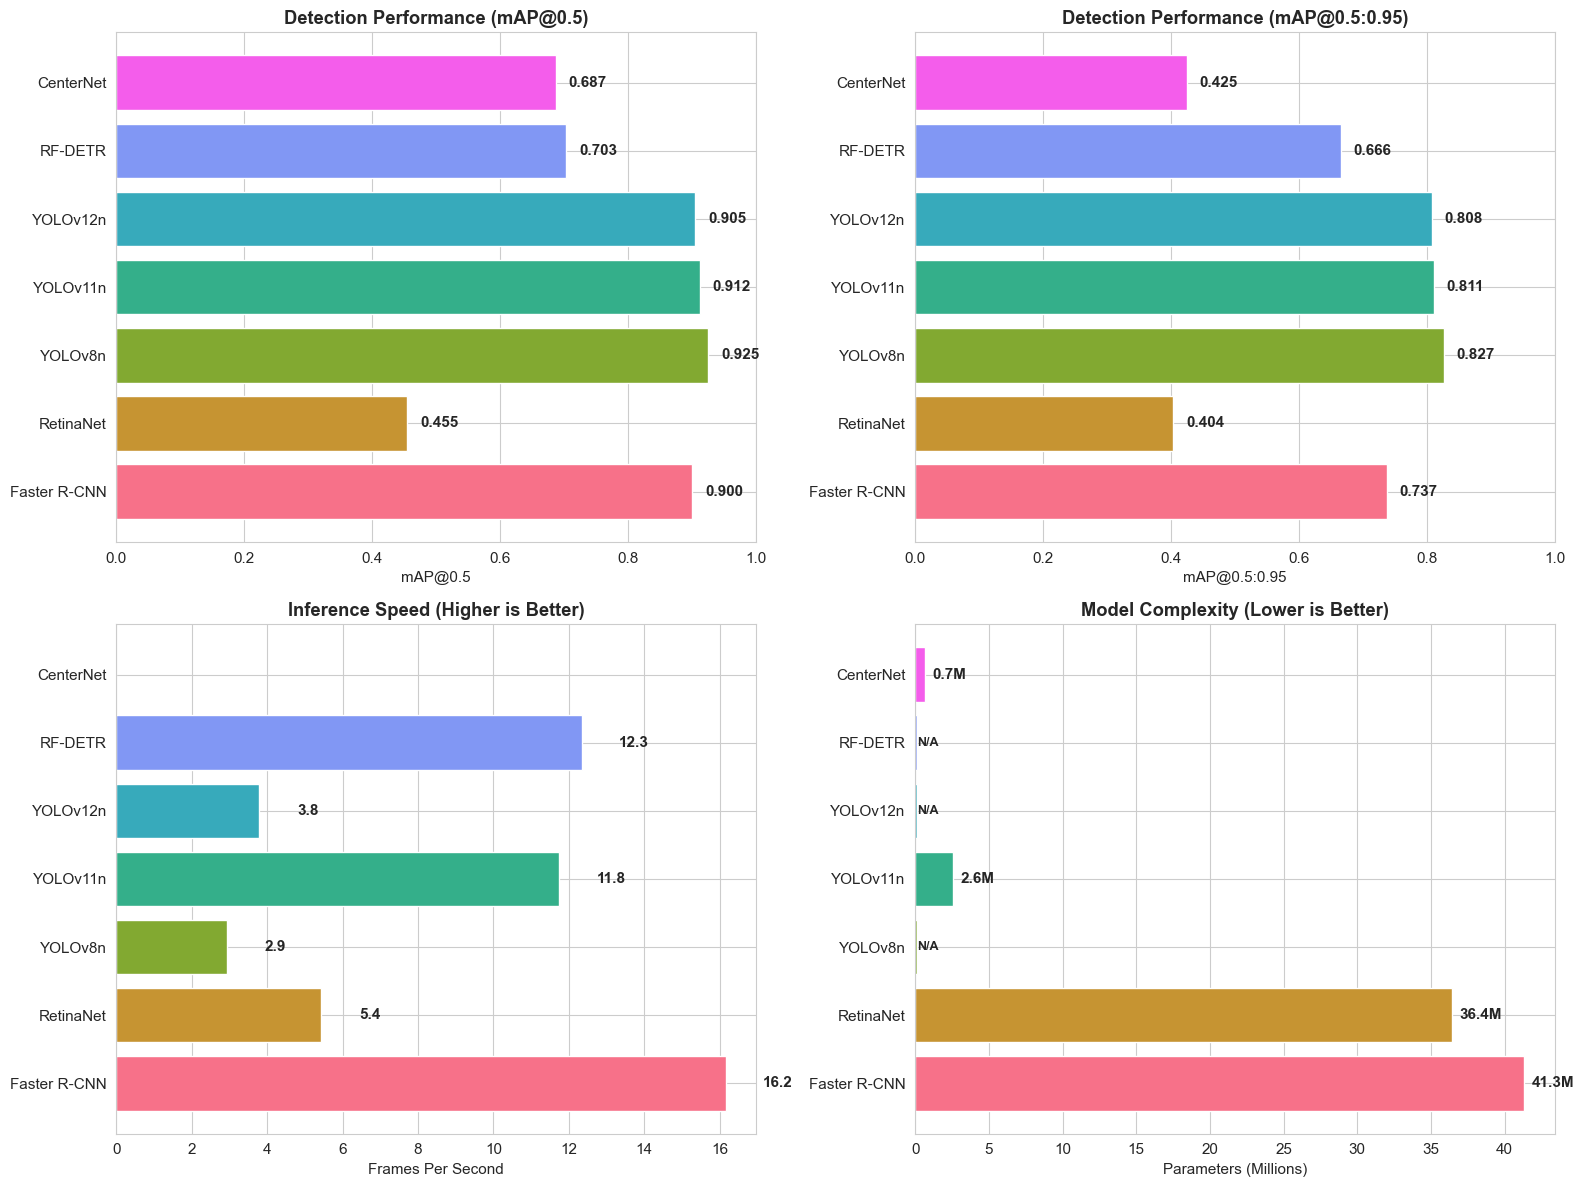

Performance metrics comparison saved to comparison_outputs/


In [35]:
# Extract numeric data for plotting
plot_models = {k: v for k, v in models_2a.items() if v is not None}

def safe_get_metric(results, *keys, default=0):
    """Try multiple possible keys and return the first one found."""
    for key in keys:
        if key in results.get('metrics', {}):
            return results['metrics'][key]
    return default

def safe_get(results, *path, default=0):
    """Safely navigate nested dict."""
    value = results
    for key in path:
        if isinstance(value, dict):
            value = value.get(key, default)
            if value == default:
                return default
        else:
            return default
    return value if value is not None else default

model_names = list(plot_models.keys())
map50 = [safe_get_metric(m, 'AP50', 'ap50', 'mAP50') for m in plot_models.values()]
map50_95 = [safe_get_metric(m, 'mAP', 'map') for m in plot_models.values()]
fps = [safe_get(m, 'speed', 'FPS', default=0) for m in plot_models.values()]
params_raw = [safe_get(m, 'model_complexity', 'num_parameters', default=0) for m in plot_models.values()]

# Filter out models with 0 params for the params chart
params = [p/1e6 for p in params_raw]
params_display = [p if p > 0 else 0.1 for p in params]  # Show tiny bar for missing data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# mAP@50
colors = sns.color_palette("husl", len(model_names))
ax1.barh(model_names, map50, color=colors)
ax1.set_xlabel('mAP@0.5')
ax1.set_title('Detection Performance (mAP@0.5)', fontweight='bold')
ax1.set_xlim(0, 1)
for i, v in enumerate(map50):
    ax1.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

# mAP@50:95
ax2.barh(model_names, map50_95, color=colors)
ax2.set_xlabel('mAP@0.5:0.95')
ax2.set_title('Detection Performance (mAP@0.5:0.95)', fontweight='bold')
ax2.set_xlim(0, 1)
for i, v in enumerate(map50_95):
    ax2.text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

# FPS
ax3.barh(model_names, fps, color=colors)
ax3.set_xlabel('Frames Per Second')
ax3.set_title('Inference Speed (Higher is Better)', fontweight='bold')
for i, v in enumerate(fps):
    if v > 0:
        ax3.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold')

# Model Size (use display values but label with real values)
ax4.barh(model_names, params_display, color=colors)
ax4.set_xlabel('Parameters (Millions)')
ax4.set_title('Model Complexity (Lower is Better)', fontweight='bold')
for i, (v_real, v_display) in enumerate(zip(params, params_display)):
    if v_real > 0:
        ax4.text(v_display + 0.5, i, f'{v_real:.1f}M', va='center', fontweight='bold')
    else:
        ax4.text(v_display + 0.05, i, 'N/A', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('comparison_outputs/2a_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Performance metrics comparison saved to comparison_outputs/")

## Speed vs Accuracy Trade-off

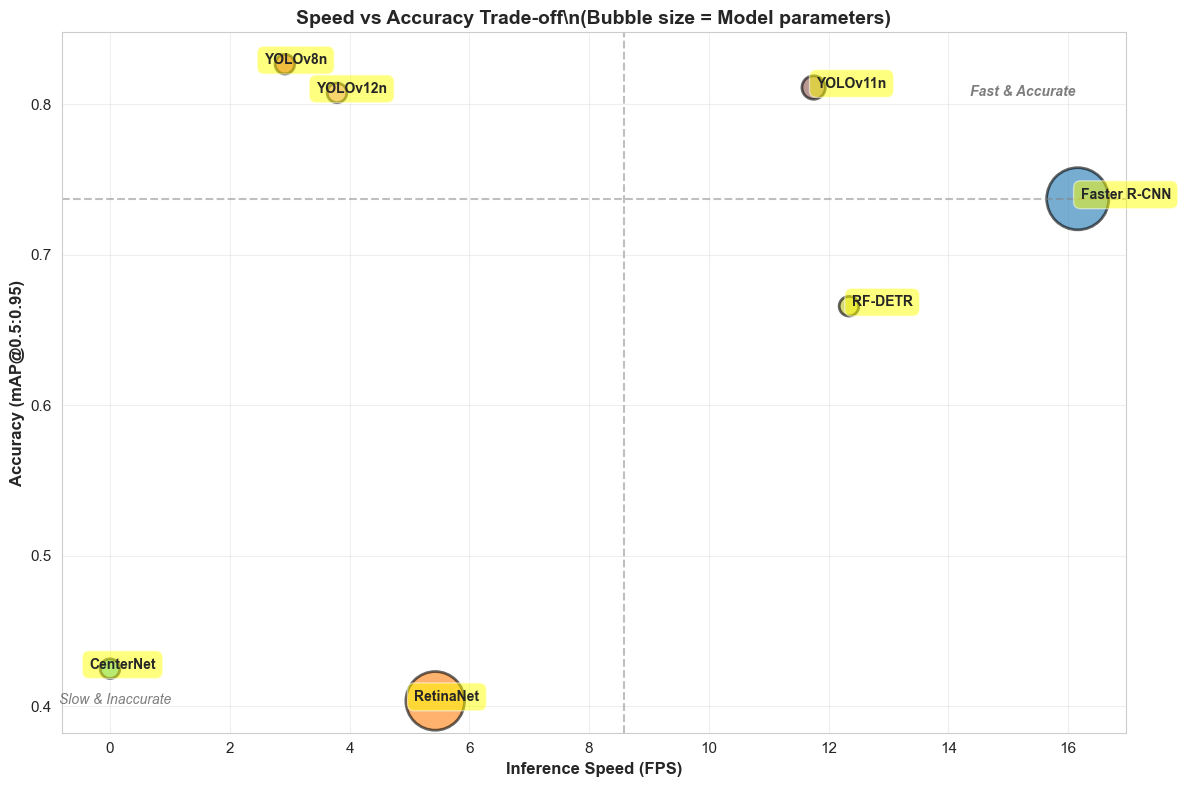

Speed vs accuracy trade-off plot saved to comparison_outputs/


In [36]:
# Scatter plot: FPS vs mAP
fig, ax = plt.subplots(figsize=(12, 8))

# Normalize bubble sizes for better visibility (200-2000 range)
if max(params) > 0:
    valid_params = [p for p in params if p > 0]
    min_p, max_p = min(valid_params), max(valid_params)
    if min_p == max_p:  # All params are the same
        bubble_sizes = [1000 if p > 0 else 200 for p in params]
    else:  # Normalize to 200-2000 range
        bubble_sizes = [((p - min_p) / (max_p - min_p) * 1800 + 200) if p > 0 else 200 for p in params]
else:  # No param data available
    bubble_sizes = [200] * len(params)

scatter = ax.scatter(fps, map50_95, s=bubble_sizes, 
                     c=range(len(model_names)), cmap='tab10', 
                     alpha=0.6, edgecolors='black', linewidth=2)

# Add model labels
for i, name in enumerate(model_names):
    # Offset labels to avoid overlap
    offset_x = 2 if fps[i] > np.median(fps) else -15
    offset_y = 0.01
    ax.annotate(name, (fps[i], map50_95[i]), 
               xytext=(offset_x, offset_y), textcoords='offset points',
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

ax.set_xlabel('Inference Speed (FPS)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (mAP@0.5:0.95)', fontsize=12, fontweight='bold')
ax.set_title('Speed vs Accuracy Trade-off\\n(Bubble size = Model parameters)', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add quadrant lines
if len(fps) > 1 and len(map50_95) > 1:
    median_fps = np.median([f for f in fps if f > 0])
    median_map = np.median([m for m in map50_95 if m > 0])
    ax.axvline(median_fps, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(median_map, color='gray', linestyle='--', alpha=0.5)
    
    # Quadrant labels
    ax.text(ax.get_xlim()[1]*0.95, ax.get_ylim()[1]*0.95, 'Fast & Accurate', 
           ha='right', fontsize=10, style='italic', alpha=0.6, fontweight='bold')
    ax.text(ax.get_xlim()[0]*1.05, ax.get_ylim()[0]*1.05, 'Slow & Inaccurate', 
           ha='left', fontsize=10, style='italic', alpha=0.6)

plt.tight_layout()
plt.savefig('comparison_outputs/2a_speed_vs_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("Speed vs accuracy trade-off plot saved to comparison_outputs/")

## Per-Class Performance Comparison

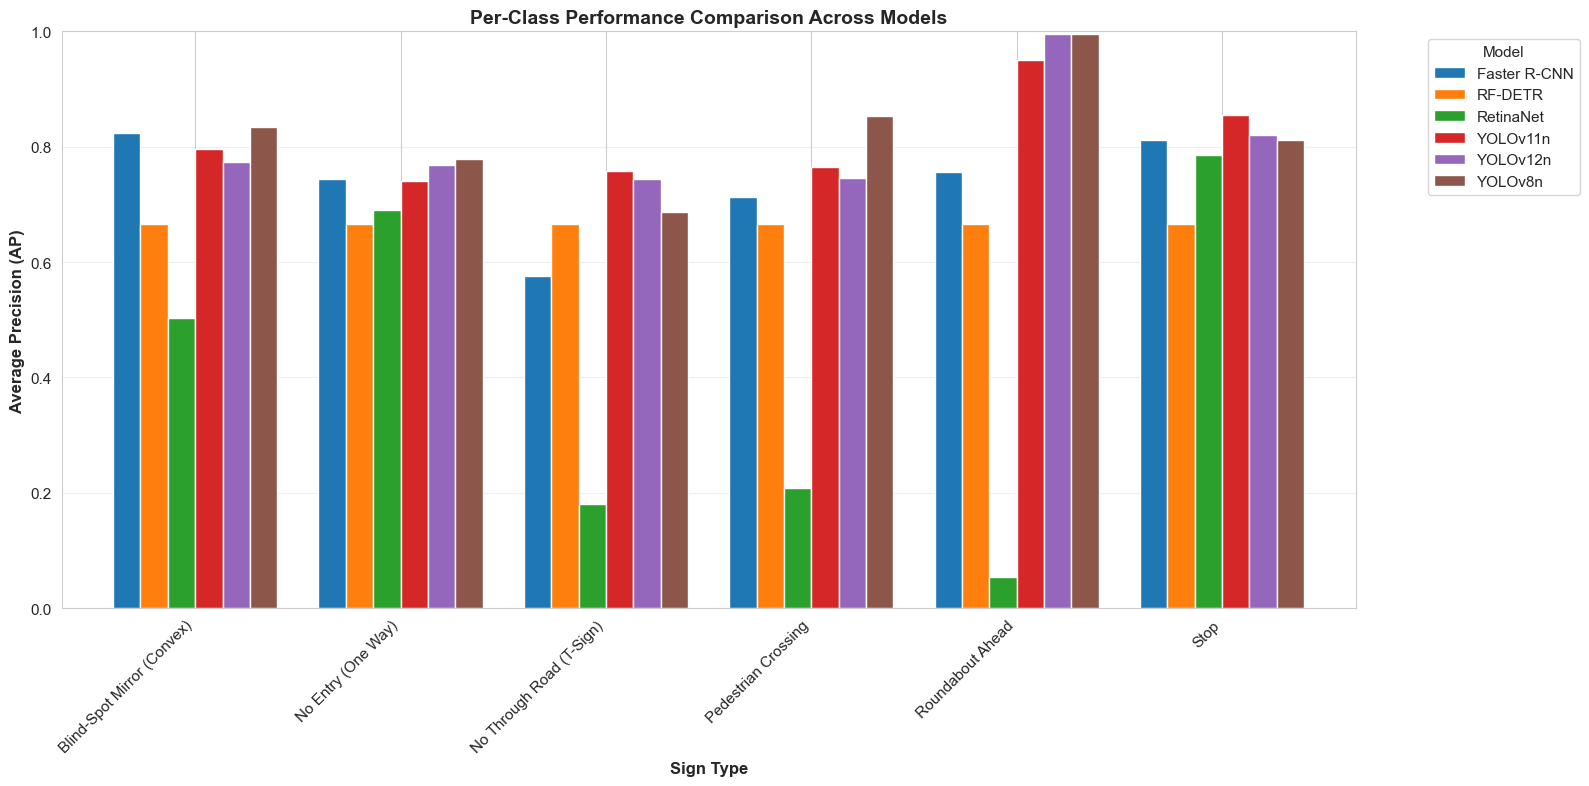

Per-class performance comparison saved to comparison_outputs/

Weakest Class Per Model:
Faster R-CNN        : No Through Road (T-Sign)                 (AP=0.577)
RetinaNet           : Roundabout Ahead                         (AP=0.053)
YOLOv8n             : No Through Road (T-Sign)                 (AP=0.687)
YOLOv11n            : No Entry (One Way)                       (AP=0.741)
YOLOv12n            : No Through Road (T-Sign)                 (AP=0.743)
RF-DETR             : Blind-Spot Mirror (Convex)               (AP=0.666)
CenterNet           : No per-class data available


In [37]:
# Extract per-class AP for each model
per_class_data = []
for model_name, results in plot_models.items():
    per_class_dict = results.get('metrics', {}).get('per_class_AP', {})
    if per_class_dict:
        for class_name, ap in per_class_dict.items():
            per_class_data.append({
                'Model': model_name,
                'Class': class_name,
                'AP': ap
            })

if len(per_class_data) > 0:
    df_per_class = pd.DataFrame(per_class_data)
    
    # Get class names from first model that has per_class data
    class_names = df_per_class['Class'].unique()
    
    # Grouped bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    df_pivot = df_per_class.pivot(index='Class', columns='Model', values='AP')
    df_pivot.plot(kind='bar', ax=ax, width=0.8)
    
    ax.set_ylabel('Average Precision (AP)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sign Type', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Performance Comparison Across Models', fontsize=14, fontweight='bold')
    ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('comparison_outputs/2a_per_class.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Per-class performance comparison saved to comparison_outputs/")
    
    # Show which class each model struggles with most
    print("\nWeakest Class Per Model:")
    for model_name, results in plot_models.items():
        per_class = results.get('metrics', {}).get('per_class_AP', {})
        if per_class:
            worst_class = min(per_class, key=per_class.get)
            worst_ap = per_class[worst_class]
            print(f"{model_name:20s}: {worst_class:40s} (AP={worst_ap:.3f})")
        else:
            print(f"{model_name:20s}: No per-class data available")

## YOLO Models: Detailed Comparison

YOLOv8 vs YOLOv11 vs YOLOv12

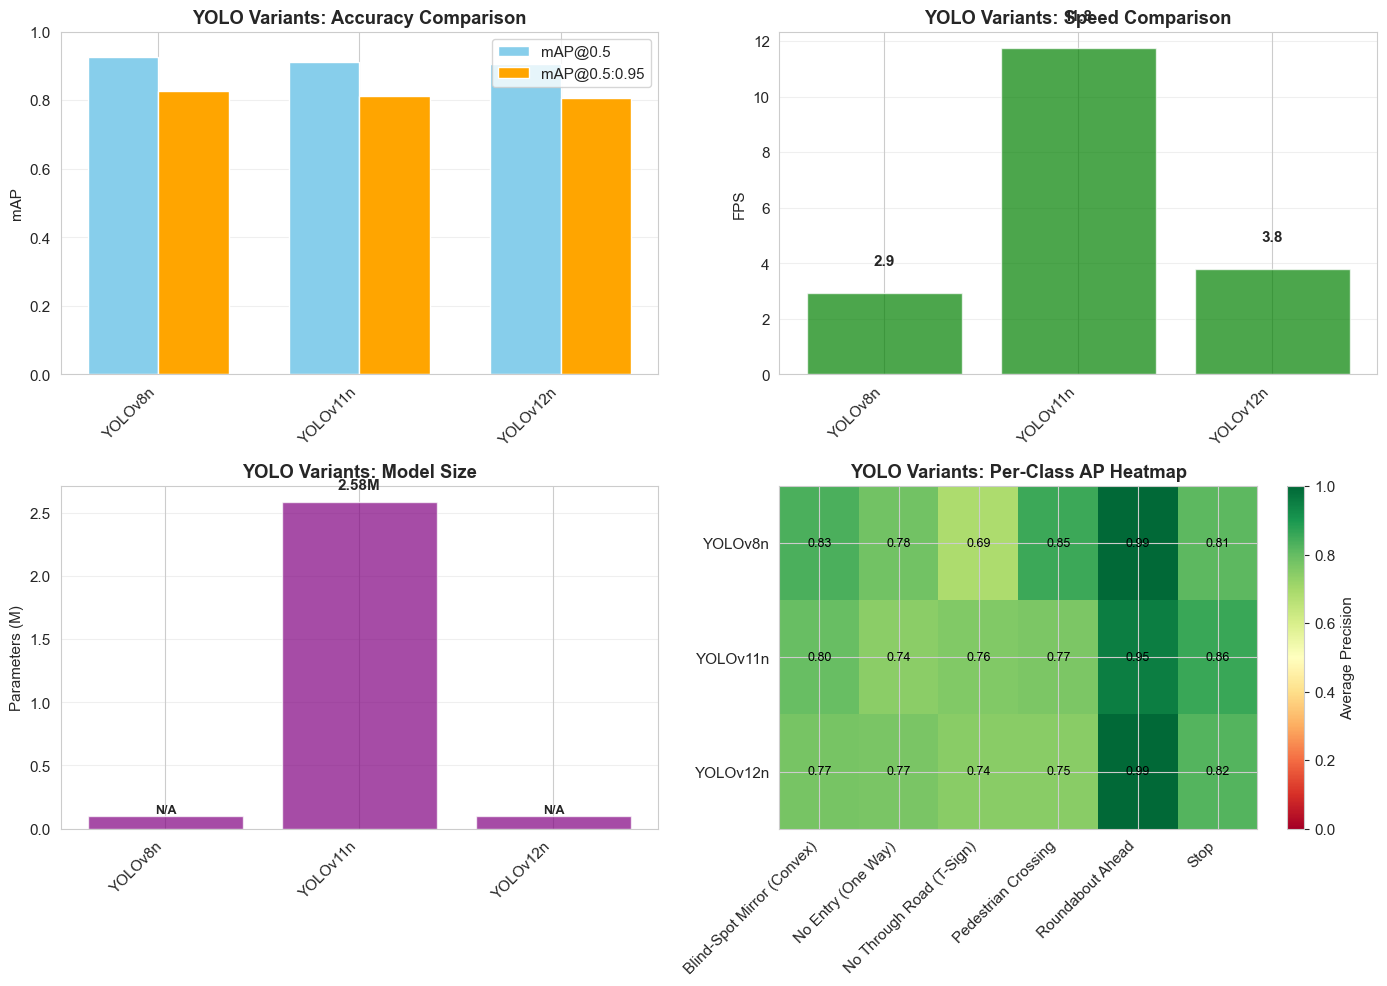

YOLO detailed comparison saved to comparison_outputs/


In [38]:
# Extract YOLO models 
yolo_models = {k: v for k, v in models_2a.items() if 'YOLO' in k and v is not None}

def safe_get_metric(results, *keys, default=0):
    """Try multiple possible keys and return the first one found."""
    for key in keys:
        if key in results.get('metrics', {}):
            return results['metrics'][key]
    return default

def safe_get(results, *path, default=0):
    """Safely navigate nested dict."""
    value = results
    for key in path:
        if isinstance(value, dict):
            value = value.get(key, default)
            if value == default:
                return default
        else:
            return default
    return value if value is not None else default

if len(yolo_models) > 0:
    yolo_names = list(yolo_models.keys())
    yolo_map50 = [safe_get_metric(m, 'AP50', 'ap50', 'mAP50') for m in yolo_models.values()]
    yolo_map = [safe_get_metric(m, 'mAP', 'map') for m in yolo_models.values()]
    yolo_fps = [safe_get(m, 'speed', 'FPS', default=0) for m in yolo_models.values()]
    yolo_params_raw = [safe_get(m, 'model_complexity', 'num_parameters', default=0)/1e6 for m in yolo_models.values()]
    
    # For display: show tiny bar for missing data
    yolo_params = [p if p > 0 else 0 for p in yolo_params_raw]
    yolo_params_display = [p if p > 0 else 0.1 for p in yolo_params_raw]
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
    
    # mAP comparison
    x = np.arange(len(yolo_names))
    width = 0.35
    ax1.bar(x - width/2, yolo_map50, width, label='mAP@0.5', color='skyblue')
    ax1.bar(x + width/2, yolo_map, width, label='mAP@0.5:0.95', color='orange')
    ax1.set_ylabel('mAP')
    ax1.set_title('YOLO Variants: Accuracy Comparison', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(yolo_names, rotation=45, ha='right')
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.grid(axis='y', alpha=0.3)
    
    # FPS comparison
    ax2.bar(yolo_names, yolo_fps, color='green', alpha=0.7)
    ax2.set_ylabel('FPS')
    ax2.set_title('YOLO Variants: Speed Comparison', fontweight='bold')
    ax2.set_xticklabels(yolo_names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    for i, v in enumerate(yolo_fps):
        if v > 0:
            ax2.text(i, v + 1, f'{v:.1f}', ha='center', fontweight='bold')
    
    # Parameters (with handling for missing data)
    ax3.bar(yolo_names, yolo_params_display, color='purple', alpha=0.7)
    ax3.set_ylabel('Parameters (M)')
    ax3.set_title('YOLO Variants: Model Size', fontweight='bold')
    ax3.set_xticklabels(yolo_names, rotation=45, ha='right')
    ax3.grid(axis='y', alpha=0.3)
    for i, (v_real, v_display) in enumerate(zip(yolo_params, yolo_params_display)):
        if v_real > 0:
            ax3.text(i, v_display + 0.1, f'{v_real:.2f}M', ha='center', fontweight='bold')
        else:
            ax3.text(i, v_display + 0.02, 'N/A', ha='center', fontweight='bold', fontsize=9)
    
    # Per-class AP heatmap
    yolo_per_class = []
    for model_name in yolo_names:
        per_class_dict = yolo_models[model_name].get('metrics', {}).get('per_class_AP', {})
        if per_class_dict:
            per_class = list(per_class_dict.values())
            yolo_per_class.append(per_class)
    
    if len(yolo_per_class) > 0:
        yolo_per_class = np.array(yolo_per_class)
        class_names = list(yolo_models[yolo_names[0]]['metrics']['per_class_AP'].keys())
        
        im = ax4.imshow(yolo_per_class, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        ax4.set_yticks(np.arange(len(yolo_names)))
        ax4.set_yticklabels(yolo_names)
        ax4.set_xticks(np.arange(len(class_names)))
        ax4.set_xticklabels(class_names, rotation=45, ha='right')
        ax4.set_title('YOLO Variants: Per-Class AP Heatmap', fontweight='bold')
        
        # Add values to heatmap
        for i in range(len(yolo_names)):
            for j in range(len(class_names)):
                text = ax4.text(j, i, f'{yolo_per_class[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=9)
        
        plt.colorbar(im, ax=ax4, label='Average Precision')
    else:
        ax4.text(0.5, 0.5, 'Per-class data not available', 
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_xticks([])
        ax4.set_yticks([])
    
    plt.tight_layout()
    plt.savefig('comparison_outputs/2a_yolo_detailed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("YOLO detailed comparison saved to comparison_outputs/")


## Confusion Matrices: Side-by-Side

Available for YOLO models

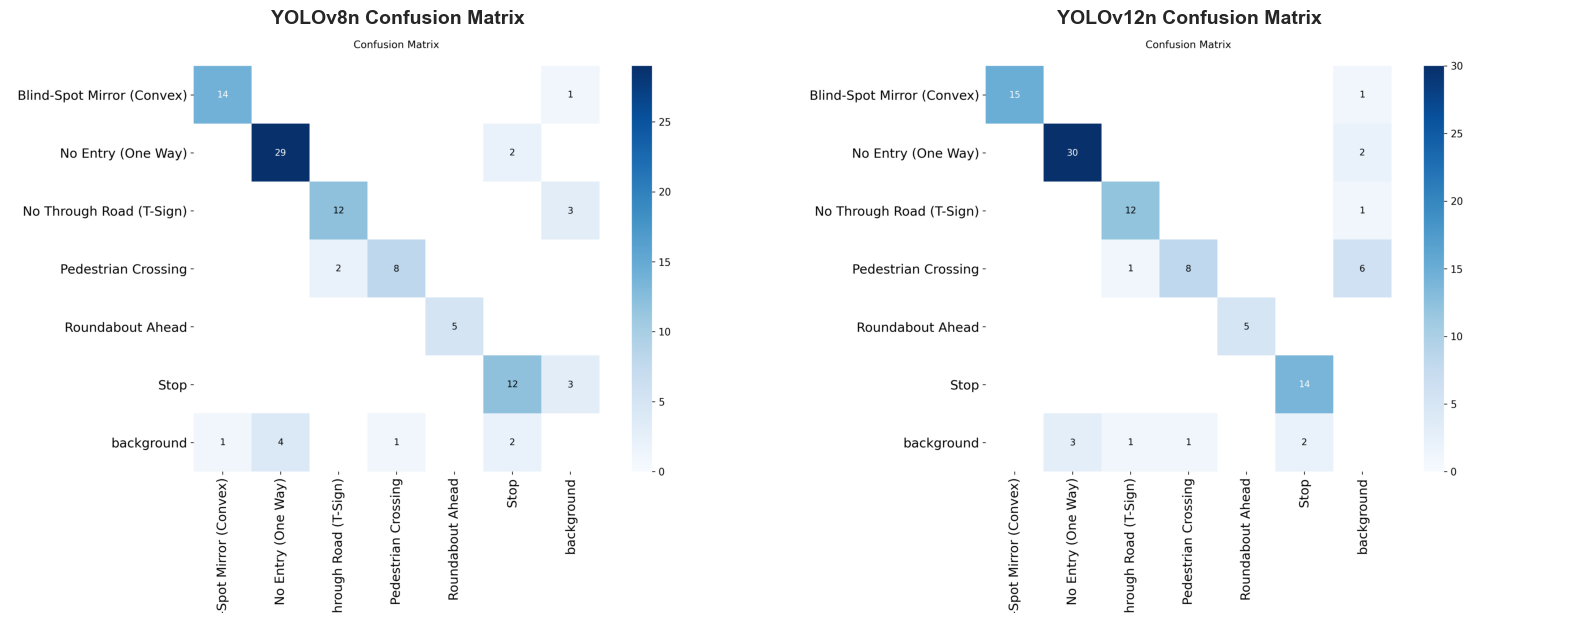

Confusion matrices comparison saved to comparison_outputs/


In [39]:
# Load and display confusion matrices for YOLO models
from pathlib import Path

confusion_paths = {
    'YOLOv8n': 'work_dirs/yolov8_sign_type/confusion_matrix.png',
    'YOLOv12n': 'work_dirs/yolov12_sign_type/confusion_matrix.png',
}

available = {k: v for k, v in confusion_paths.items() if Path(v).exists()}

if len(available) > 0:
    n_models = len(available)
    fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 8))
    
    if n_models == 1:
        axes = [axes]
    
    for idx, (name, path) in enumerate(available.items()):
        img = Image.open(path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'{name} Confusion Matrix', fontsize=14, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_outputs/2a_confusion_matrices.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Confusion matrices comparison saved to comparison_outputs/")


## Key Observations: Task 2a

In [40]:
# Identify best models for different criteria
def safe_get_metric(results, *keys, default=0):
    """Try multiple possible keys and return the first one found."""
    for key in keys:
        if key in results.get('metrics', {}):
            return results['metrics'][key]
    return default

def safe_get(results, *path, default=0):
    """Safely navigate nested dict."""
    value = results
    for key in path:
        if isinstance(value, dict):
            value = value.get(key, default)
            if value == default:
                return default
        else:
            return default
    return value if value is not None else default

print("TASK 2A: KEY FINDINGS")
print()

# Best accuracy
best_accuracy = max(plot_models.items(), key=lambda x: safe_get_metric(x[1], 'mAP', 'map'))
print(f"BEST ACCURACY: {best_accuracy[0]}")
print(f"  mAP@0.5:0.95 = {safe_get_metric(best_accuracy[1], 'mAP', 'map'):.4f}")
print(f"  mAP@0.5 = {safe_get_metric(best_accuracy[1], 'AP50', 'ap50'):.4f}")
print()

# Fastest
fastest = max(plot_models.items(), key=lambda x: safe_get(x[1], 'speed', 'FPS', default=0))
print(f"FASTEST: {fastest[0]}")
print(f"  FPS = {safe_get(fastest[1], 'speed', 'FPS', default=0):.1f}")
print(f"  mAP@0.5:0.95 = {safe_get_metric(fastest[1], 'mAP', 'map'):.4f}")
print()

# Most efficient (smallest)
smallest = min(plot_models.items(), key=lambda x: safe_get(x[1], 'model_complexity', 'num_parameters', default=1e9))
print(f"SMALLEST: {smallest[0]}")
num_params = safe_get(smallest[1], 'model_complexity', 'num_parameters', default=0)
print(f"  Parameters = {num_params/1e6:.2f}M" if num_params > 0 else "  Parameters = N/A")
print(f"  mAP@0.5:0.95 = {safe_get_metric(smallest[1], 'mAP', 'map'):.4f}")
print()

# Best trade-off 
efficiency = {}
for k, v in plot_models.items():
    num_params = safe_get(v, 'model_complexity', 'num_parameters', default=0)
    map_val = safe_get_metric(v, 'mAP', 'map')
    if num_params > 0 and map_val > 0:
        efficiency[k] = map_val / (num_params/1e6)

if len(efficiency) > 0:
    best_efficiency = max(efficiency.items(), key=lambda x: x[1])
    print(f"BEST EFFICIENCY: {best_efficiency[0]}")
    print(f"  mAP per million parameters = {best_efficiency[1]:.4f}")
    print()
else:
    print("BEST EFFICIENCY: N/A (parameter data not available)")
    print()

TASK 2A: KEY FINDINGS

BEST ACCURACY: YOLOv8n
  mAP@0.5:0.95 = 0.8266
  mAP@0.5 = 0.9250

FASTEST: Faster R-CNN
  FPS = 16.2
  mAP@0.5:0.95 = 0.7372

SMALLEST: RF-DETR
  Parameters = N/A
  mAP@0.5:0.95 = 0.6658

BEST EFFICIENCY: CenterNet
  mAP per million parameters = 0.6299



# Task 2b: Viewing Angle Detection
## Overview

In [41]:
def safe_get_metric(results, *keys, default=0):
    """Try multiple possible keys and return the first one found."""
    for key in keys:
        if key in results.get('metrics', {}):
            return results['metrics'][key]
    return default

def safe_get(results, *path, default=0):
    """Safely navigate nested dict."""
    value = results
    for key in path:
        if isinstance(value, dict):
            value = value.get(key, default)
            if value == default:
                return default
        else:
            return default
    return value if value is not None else default

print("TASK 2B: VIEWING ANGLE DETECTION")
print()

for name, results in models_2b.items():
    print(f"Model: {name}")
    print(f"  mAP@0.5:0.95: {safe_get_metric(results, 'mAP', 'map'):.4f}")
    print(f"  mAP@0.5: {safe_get_metric(results, 'AP50', 'ap50'):.4f}")
    fps = safe_get(results, 'speed', 'FPS', default=0)
    print(f"  FPS: {fps:.1f}" if fps > 0 else "  FPS: N/A")
    
    num_params = safe_get(results, 'model_complexity', 'num_parameters', default=0)
    if num_params > 0:
        print(f"  Parameters: {num_params/1e6:.2f}M")
    else:
        print(f"  Parameters: N/A")
    
    print()
    per_class_dict = results.get('metrics', {}).get('per_class_AP', {})
    if per_class_dict:
        print("Per-Angle Performance:")
        for angle, ap in per_class_dict.items():
            print(f"    {angle}: {ap:.4f}")
    else:
        print("Per-Angle Performance: N/A")
    print()

TASK 2B: VIEWING ANGLE DETECTION

Model: Faster R-CNN
  mAP@0.5:0.95: 0.7349
  mAP@0.5: 0.8695
  FPS: 18.5
  Parameters: 41.31M

Per-Angle Performance:
    Back: 0.7740
    Front: 0.8762
    Side: 0.5544

